---
### *The 11th Computational Neuroscience Winter School*

# Tutorial II: Data Analysis - Causal Inference
---

__Date:__ Jan. 19, 2022

__Content Creator:__ Kai Chen

# Tutorial Objectives

In this notebook, we'll learn how to do causal inferece between two time series by applying types of inference tools. More importantly, we gonna to compare performances of these methods. 

1. Mathematical definition of Causality and commonly used method to crack causality.
1. Introduction to Granger Causality.
1. Introduction to time-delayed mutual informaiton.
1. Causal inference in linear and nonlinear systems.
1. Causal inference for experimental data.


#### References:
- D. Zhou, Y. Xiao, Y. Zhang, Z. Xu and D. Cai, “Granger causality network reconstruction of conductance-based integrate-and-fire neuronal systems”, PLoS ONE, 9 (2), e87636, 2014. ([PDF](https://ins.sjtu.edu.cn/people/zdz/publication_papers/Granger_Causality_Reconstruction.pdf))
- S. Li, Y. Xiao, D. Zhou and D. Cai, “Causal inference in nonlinear systems: Granger causality versus time-delayed mutual information”, Phys. Rev. E, 97 (5), 052216, 2018. ([PDF](https://ins.sjtu.edu.cn/people/zdz/publication_papers/Granger_causality_versus_time_delayed_mutual_information.pdf))
- Matlab-based fast GC-estimator: [GC_clean](https://github.com/bewantbe/GC_clean)
- Python-based mutual-information estimator: [mutual-information](https://github.com/NeoNeuron/mutual_information)
- SciPy $\chi^2$ statistics [documents](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2.html).

---
# Setup

In [1]:
# @title Import most modules and functions needed
import time
import numpy as np
from scipy.stats import chi2
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['axes.titlesize'] = 18
import matplotlib.pyplot as plt
import ipywidgets as widgets
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Section 1: Defining and estimating causality
**This part is borrow from Neuromatch Academay Course Material 2020.**


Let's think carefully about the statement "**A causes B**". To be concrete, let's take two neurons. What does it mean to say that neuron $A$ causes neuron $B$ to fire?

The *interventional* definition of causality says that:
$$
(A \text{ causes } B) \Leftrightarrow ( \text{ If we force }A \text { to be different, then }B\text{ changes})
$$

To determine if $A$ causes $B$ to fire, we can inject current into neuron $A$ and see what happens to $B$.

**A mathematical definition of causality**: 
Over many trials, the average causal effect $\delta_{A\to B}$ of neuron $A$ upon neuron $B$ is the average change in neuron $B$'s activity when we set $A=1$ versus when we set $A=0$.


$$
\delta_{A\to B} = \mathbb{E}[B | A=1] -  \mathbb{E}[B | A=0] 
$$

Note that this is an average effect. While one can get more sophisticated about conditional effects ($A$ only effects $B$ when it's not refractory, perhaps), we will only consider average effects here.


## Exercise 1: Randomized controlled trial for two neurons

Let's pretend we can perform a randomized controlled trial for two neurons. Our model will have neuron $A$ synapsing on Neuron $B$:
$$B = A + \varepsilon$$
 where $A$ and $B$ represent the activities of the two neurons and $\varepsilon$ is standard normal noise $\varepsilon\sim\mathcal{N}(0,1)$.

Our goal is to infer the mono-synaptic interactions from $A$ to $B$, i.e., the change of $B$ is induced by activity of $A$(if we ignore the effect of noise). 

In [2]:
def neuron_B(activity_of_A):
    """Model activity of neuron B as neuron A activity + noise

    Args:
    activity_of_A (ndarray): An array of shape (T,) containing the neural activity of neuron A

    Returns:
    ndarray: activity of neuron B
    """
    noise = np.random.randn(activity_of_A.shape[0])
    return activity_of_A + noise

np.random.seed(2021)

# Neuron A activity of zeros
A_0 = np.zeros(50000)

# Neuron A activity of ones
A_1 = np.ones(50000)

# TODO : Estimate the causal effect of A upon B
# Use eq above (difference in mean of B when A=0 vs. A=1)
diff_in_means = neuron_B(A_1).mean()- neuron_B(A_0).mean()
print(diff_in_means)

1.0021386162662929


However, empirically, we cannot expect the frequently appearance of the cases $A=0$ or $A=1$. Then, we may do some relexiation and modified the original expression of causality a little bit, as

$$
\delta_{A\to B} = \mathbb{E}[B | A\geq\theta] -  \mathbb{E}[B | A<\theta] 
$$

Note that this is an average effect. While one can get more sophisticated about conditional effects ($A$ only effects $B$ when it's not refractory, perhaps), we will only consider average effects here.


In [3]:
# Neuron A activity of uniformly distributed iid random variables
np.random.seed(2021)
A = np.random.rand(50000)

theta = 0.5
# TODO : Estimate the causal effect of A upon B
# Use eq above (difference in mean of B when A>= theta vs. A<theta)
B = neuron_B(A)
diff_in_means = B[A>=theta].mean()- B[A<theta].mean()
print(f'[interacted case] delta A->B: {diff_in_means:.3e}')

# comparison test: using independent
B_indep = np.random.rand(50000)
diff_in_means = B_indep[A>=theta].mean()- B_indep[A<theta].mean()
print(f'[independent case] delta A->B: {diff_in_means:.3e}')

[interacted case] delta A->B: 5.084e-01
[independent case] delta A->B: 5.580e-04


---
# Section 2: Granger Causality

So far we can see that it is possible to estimate causality from experimental data, time series. And there are a mount of tools that can be used to investigate the causality, including
- Perturbations
- Correlations
- Simultaneous fitting/regression
- Instrumental variables
- etc...

All of them work well in some cases and fail in other cases. Thus, we should be very careful by keeping in mind the advantages and weaknesses of different tools of causal inference.

And today, we are going to play with two types of model-free methods of estimating causality. Firstly, Granger causality(GC). The original paper of GC is [here](https://www.jstor.org/stable/1912791?origin=crossref&seq=1#metadata_info_tab_contents). GC is developed from the linear regression analysis, and the basic idea goes as follows.

Suppose we have two time series {$x_t$} and {$y_t$}. The first thing we can do is the auto-regression analysis for the time series {$x_t$}.

$$
x_{t}=\sum_{i=1}^{m} \hat{a}_{i} x_{t-i}+\hat{\varepsilon}_{t}
$$
where $m$ is the regression order, $\hat{a}_{i}$ is the regression coefficient, and $\hat{\varepsilon}_{t}$ is the residue after auto-regression. Similarly, we can do joint regression analysis of {$x_t$} by taking the information of time series {$y_t$} into account.
$$
x_{t}=\sum_{i=1}^{m} a_{i} x_{t-i}+\sum_{j=1}^{m} b_{j} y_{t-j}+\varepsilon_{t}.
$$
Similarly, $m$ is the regression order, $a_i$, $b_j$ is the regression coefficient, and $\varepsilon_t$ is the residual of joint regression analysis.

Now it comes to the key step of GC analysis. Once you got residuals from two different regression, you may start to compare the variance of these two regression. The definition of GC from $y$ to $x$ in time domain is defined as

$$
F_{y \rightarrow x}=\log \frac{\operatorname{var}\left(\hat{\varepsilon}_{t}\right)}{\operatorname{var}\left(\varepsilon_{t}\right)}
$$

Intuitively speaking, if {$y_t$} do have causal effect onto {$x_t$}, the participation of information of $y_t$ will definitely help improve the regression analysis and lead to smaller variance of regression residual, i.e., $\text{Var}(\hat{\varepsilon}_t)>\text{Var}(\varepsilon_t)$.

On the other hand, if {$x_t$} and {$y_t$} are completely independent, the set of joint regression coefficient $b_j=0$, which leads to $\text{Var}(\hat{\varepsilon}_t)=\text{Var}(\varepsilon_t)$. Therefore, $F_{y\rightarrow x}=0$.

Now, let's start to build up codes for estimating GC and play with some generated data.


### Step 1: Create structure array for regression analysis.

Rewrite the auto regression model into matrix form as
$$
\mathbf{x}_{t}= \mathbf{X}\mathbf{a}+\mathbf{\hat{\varepsilon}_t}
$$

where $\mathbf{X}_{(t-m)\times m} = \left[\mathbf{x}_{t-1}, \mathbf{x}_{t-2}, \cdots, \mathbf{x}_{t-m}\right]$, and $\mathbf{a} = \left[a_1, a_2, \cdots, a_m\right]^T$. Here, $\mathbf{X}$ is the structure array that we want in the regression model. 

Similarly for joint regression case,

$$
\mathbf{x}_{t}= \mathbf{Z}\mathbf{p}+\mathbf{\varepsilon_t}
$$

where $\mathbf{Z}_{(t-m)\times 2m} = \left[\mathbf{x}_{t-1}, \mathbf{x}_{t-2}, \cdots, \mathbf{x}_{t-m}, \mathbf{y}_{t-1}, \mathbf{y}_{t-2}, \cdots, \mathbf{y}_{t-m}\right]$, and $\mathbf{p} = \left[a_1, a_2, \cdots, a_m, b_1, \cdots, b_m\right]^T$.


In [4]:
def create_structure_array(x:np.ndarray, order:int)->np.ndarray:
    '''
    Prepare structure array for regression analysis.
    
    Args:
    x         : original time series
    order     : regression order
    
    Return:
    x_array   : structure array with shape (len(x)-order) by (order).
    
    '''
    N = len(x) - order
    x_array = np.zeros((N, order))
    for i in range(order):
        x_array[:, i] = x[-i-1-N:-i-1]
    return x_array

In [5]:
# test create_structure_array
test_X = np.random.randn(10)
X_array = create_structure_array(test_X, 3)
print(X_array)

[[ 1.29262687  0.09364842  2.12219566]
 [ 0.84809954  1.29262687  0.09364842]
 [-0.04950234  0.84809954  1.29262687]
 [-0.78180301 -0.04950234  0.84809954]
 [-0.56899468 -0.78180301 -0.04950234]
 [-1.79332419 -0.56899468 -0.78180301]
 [-0.83891719 -1.79332419 -0.56899468]]


### Step 2: Solve regression problem
After you prepare the structure array, then we need to solve the regression problem. Directly from the matrix expression of regression model, we can treat it as an optimization problem or least square problem.

$$
\min_\mathbf{a} \left\lVert\mathbf{x}_{t} - \mathbf{X}\mathbf{a}\right\rVert_2
$$

Theoretically, we can calculate it using the expression below
$$
\hat{\mathbf{a}}  = \left(\mathbf{X}^T\mathbf{X}\right)^{-1} \mathbf{X}^T\mathbf{x}_t
$$

Numerically, in order to by pass the direct matrix inverse for large matrix, here we use the least square solver in numpy, named as `numpy.linalg.lstsq()`, which use SVD to accelerate the numerical solver of least square problem.


In [6]:
def auto_reg(x, order)->np.ndarray:
    '''
    Auto regression analysis of time series.
    
    Args:
    x         : original time series
    order     : regression order
    
    Return:
    res       : residual vector
    
    '''
    reg_array = create_structure_array(x, order)
    coef = np.linalg.lstsq(reg_array, x[order:], rcond=None)[0]
    res = x[order:] - reg_array @ coef
    return res

In [7]:
# test auto_reg()
test_x = np.random.randn(10)
print(auto_reg(test_x, 3))

[-0.02618195  0.01725282 -1.14565429  0.23847969 -0.86907337 -0.56368477
 -0.3344698 ]


In [8]:
def joint_reg(x, y, order)->np.ndarray:
    '''
    Joint regression analysis of time series.
    
    Args:
    x         : original time series 1
    y         : original time series 2
    order     : regression order
    
    Return:
    res       : residual vector
    
    '''
    reg_array_x = create_structure_array(x, order)
    reg_array_y = create_structure_array(y, order)
    reg_array = np.hstack((reg_array_x, reg_array_y))
    coef = np.linalg.lstsq(reg_array, x[order:], rcond=None)[0]
    res = x[order:] - reg_array @ coef
    return res

In [9]:
# test joint_reg()
test_x = np.random.randn(10)
test_y = np.random.randn(10)
print(joint_reg(test_x, test_y, 3))

[ 0.54196886 -0.63190675  0.65399303 -0.33660473  0.84719683  0.06088387
  0.65306014]


### Step 3: Calculate GC

Using the regression model defined above to calculate GC value.

In [10]:
def GC(x, y, order):
    '''
    Granger Causality from y to x
    
    Args:
    x         : original time series (dest)
    y         : original time series (source)
    order     : regression order
    
    Return:
    GC_value  : residual vector
    
    '''
    res_auto = auto_reg(x, order)
    res_joint = joint_reg(x, y, order)
    GC_value = 2.*np.log(res_auto.std()/res_joint.std())
    return GC_value
    

In [11]:
test_X = np.random.randn(100000)
test_Y = np.random.randn(100000)
test_Y[1:] += test_X[:-1]*0.5
print(f'GC Y->X: {GC(test_X, test_Y, 100):.3e}')
print(f'GC X->Y: {GC(test_Y, test_X, 100):.3e}')

GC Y->X: 1.030e-03
GC X->Y: 2.215e-01


### Step 4: Determin the significance level of GC value.

Suppose time seies $x_t$ and $y_t$ do not have any causal relationship, then theoretically speaking, the GC value between them $F_{x\rightarrow y}$ = $F_{y\rightarrow x}$ = 0. However, due to the finite data length and finite regression order, the empirical value of GC $\tilde{F}_{x\rightarrow y}$ and $\tilde{F}_{y\rightarrow x}$ asymtotically follows $\chi^2$ distribution, 

$$l\tilde{F}_{x\rightarrow y},l\tilde{F}_{y\rightarrow x}\sim \chi^2(m),$$

where $l$ is the data length and $m$ is the regression order.

Using this as the null-hypothesis, we can calculate the significance level (threshold) to reject null-hypothesis with given $p$-value.

In [12]:
def GC_SI(p, order, length):
    '''
    Significant level of GC value.
    
    Args
    p       : p-value
    order   : parameter of chi^2 distribution
    length  : length of data.
    
    Return:
    significant level of null hypothesis (GC 
        between two independent time seies)
    
    '''
    return chi2.ppf(1-p, order)/length

In [13]:
length = 1e5
order = 10
p = 0.0001
print(f'GC threshold for p={p:.1e}, length={length:.1e}, order={order:d}: \
      {GC_SI(p, order, length):.3e}')

GC threshold for p=1.0e-04, length=1.0e+05, order=10:       3.556e-04


# Section 3: Time-delayed Mutual Information (TDMI)

TDMI is an information-theoretic approach for detecting causal interactions. In general, the quantity of mutual information characterizes the common information shared between two signals. Given two stationary signals X and Y with their time traces {$x_t$} and {$y_t$}, respectively, the mutual information between them is defined as
$$
I(X, Y)=\sum_{x_{t}} \sum_{y_t} p\left(x_{t}, y_{t}\right) \log \frac{p\left(x_{t}, y_{t}\right)}{p\left(x_{t}\right) p\left(y_{t}\right)}
$$
where $ p(xt ,yt )$ is the joint probability distribution of $X = x_t$ and $Y = y_t$ , $p(x_t)$ and $p(y_t)$ are their marginal probability distributions. In particular, $I (X,Y) = 0$ is equivalent to $p(x_t ,y_t) = p(x_t)p(y_t)$, which indicates that signals $X$ and $Y$ are independent if they do not share information.

Mutual information is symmetric, i.e., $I (X,Y ) = I (Y,X)$. Therefore, it cannot be applied directly to infer the direction of interactions between two signals. To overcome this limitation, one can introduce a time-lag parameter $\tau$ to capture the delay of information transfer between the two signals. TDMI as a function of time-lag $\tau$ is defined as

$$
I(X, Y, \tau)=\sum_{x_{t}} \sum_{y_{t-\tau}} p\left(x_{t}, y_{t-\tau}\right) \log \frac{p\left(x_{t}, y_{t-\tau}\right)}{p\left(x_{t}\right) p\left(y_{t-\tau}\right)}
$$

where $p(x_t ,y_{t −\tau} )$ is the joint probability distribution of $X = x_t$ and $Y = y_{t −\tau}$ . A nonzero amplitude of the mutual information as a function of $\tau$ indicates the existence of interactions between two signals; the sign of the time-lag $\tau$ where $I(X,Y,\tau)$ reaches its peak magnitude is used to infer the information flow direction that can be further interpreted as the causal direction of interaction. A negative $\tau$ indicates that $X$ shares a maximum amount of information with the future of $Y$ , thus $X$ drives $Y$. A positive $\tau$ indicates that $X$ shares a maximum amount of information with the past of $Y$, thus $X$ is driven by $Y$ .

In [104]:
# Add you code to estimate mutual information
def mi(x, y, bins = None):
    """mutual information for 0-1 binary time series
    :param x: first series
    :type x: int of ndarray
    :param y: second series
    :type y: int of ndarray
    :return: mutual information

    """
    N = len(x)
    if bins is None:
        bins = np.sqrt(N).astype(int)
    pxy,_,_ = np.histogram2d(x, y, bins)
    pxx = np.tile(pxy.sum(1), (bins, 1)).T
    pyy = np.tile(pxy.sum(0), (bins, 1))
    mask = pxy!=0
    mi_val = np.sum(pxy[mask]*np.log(pxy[mask]/pxx[mask]/pyy[mask]))
    return mi_val / N + np.log(N) 

def dmi(x, y, delay):
    if delay == 0:
        return mi(x, y)
    elif delay < 0:
        return mi(x[-delay:],y[:delay])
    elif delay > 0:
        return mi(x[:-delay],y[delay:])

def tdmi(x, y, time_range):
    return np.array([dmi(x,y,delay) for delay in time_range])

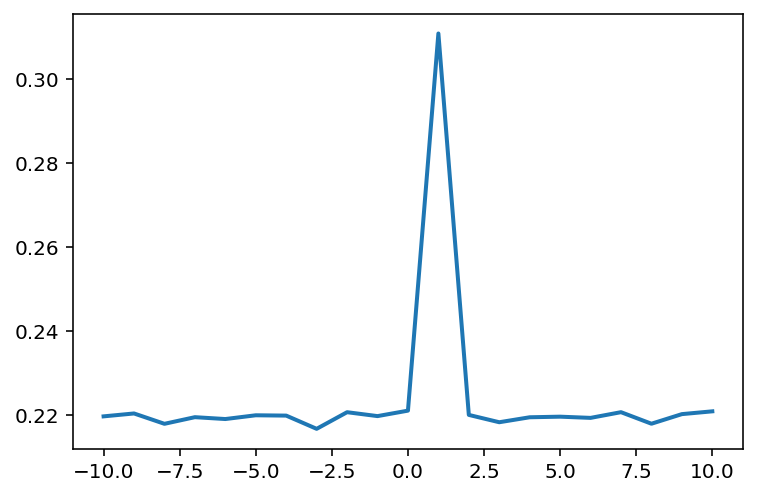

In [ ]:
# test TDMI()
test_x = np.random.randn(100000)
test_y = np.random.randn(100000)
test_y[1:] += test_x[:-1]*0.5
delay = np.arange(21)-10
plt.plot(delay, tdmi(test_x, test_y, delay))

#### [Python library for mutual information estimation](https://github.com/NeoNeuron/mutual_information)

In [ ]:
# install minfo, a Cython-based mutual information estimator;
!pip install minfo

Note that: if `ImportError` occurs later, please reinstall `numpy` with conda instead of `pip`.

In [99]:
# import mutual information estimator
from minfo.mi_float import tdmi_omp
# wrap funciotns estimating time-delayed mutual information
def TDMI(x:np.ndarray, y:np.ndarray, time_range:np.ndarray) -> np.ndarray:

    assert 0 in delay
    assert time_range.dtype == int

    tdmi_val = np.zeros_like(time_range, dtype=float)
    pos_end = np.max(time_range).astype(int)
    neg_end = -np.min(time_range).astype(int)
    if neg_end == 0:
        tdmi_val = tdmi_omp(x, y, pos_end+1)
    elif pos_end == 0:
        tdmi_val = np.flip(tdmi_omp(y, x, neg_end+1))
    else:
        tdmi_val[neg_end:] = tdmi_omp(x, y, pos_end+1)
        tdmi_val[:neg_end+1] = np.flip(tdmi_omp(y, x, neg_end+1))
    
    return tdmi_val

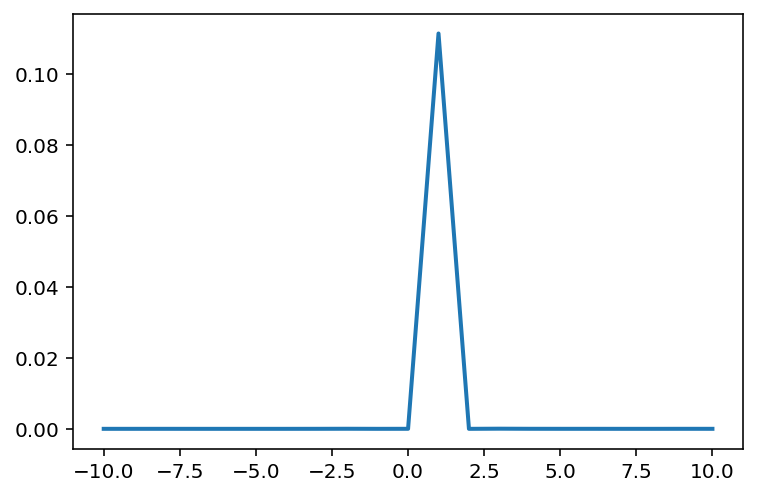

In [58]:
# test TDMI()
plt.plot(delay, TDMI(test_x, test_y, delay))

---
# Section 4: Causal inference in linear and nonlinear systems.

Now use these two methods you code above to play with few artifitially generated time series.

## Case A: Unidirection misinferred as no interaction
\begin{array}{l}x_{t}=\varepsilon_{t} \\ y_{t}=-0.1 x_{t-1}+\eta_{t}\end{array}

In [109]:
def system_A(length):
    x = np.random.randn(length)
    y = np.random.randn(length)
    y[1:] += -0.1*x[:-1]
    return x, y

In [110]:
# GC version
length = int(1e7)
order = 10
X, Y = system_A(length)
print(f'GC Y->X     : {GC(X, Y, order):.3e}')
print(f'GC X->Y     : {GC(Y, X, order):.3e}')
print(f'GC threshold: {GC_SI(0.001, order, length):.3e}')


GC Y->X     : 1.256e-06
GC X->Y     : 9.973e-03
GC threshold: 2.959e-06


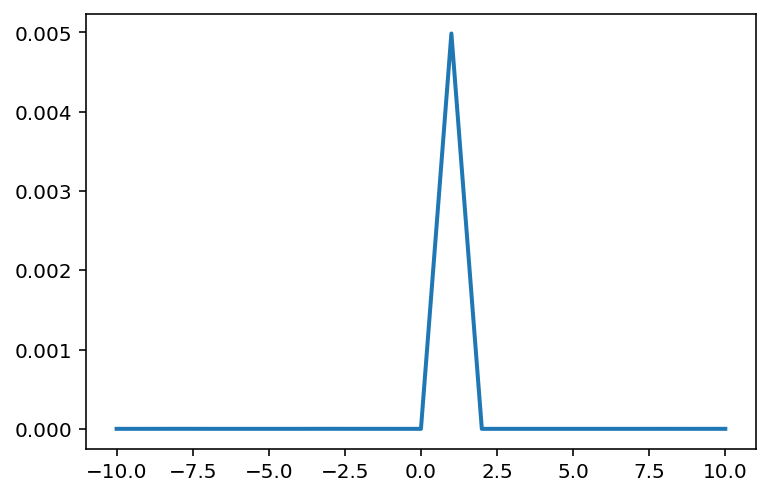

In [111]:
# TDMI version
delay = np.arange(21)-10
plt.plot(delay, TDMI(X,Y,delay))

### Nonlinear transformation
$$
\tilde{x}_t = x_t^2
$$

In [ ]:
# GC version
X_tilde = X**2
print(f'GC Y->X     : {GC(X_tilde, Y, order):.3e}')
print(f'GC X->Y     : {GC(Y, X_tilde, order):.3e}')
print(f'GC threshold: {GC_SI(0.001, order, length):.3e}')

In [ ]:
# TDMI version
delay = np.arange(21)-10
plt.plot(delay, TDMI(X_tilde,Y,delay))

## Case B: Unidirection misinferred as bidirection
\begin{array}{l}x_{t}=-0.3 x_{t-1}+\varepsilon_{t} \\ y_{t}=0.3 y_{t-1}-0.9 x_{t-1}+\eta_{t}\end{array}

In [ ]:
def system_B(length):
    x = np.random.randn(length)
    y = np.random.randn(length)
    for i in range(1, length):
        x[i] += -0.3*x[i-1]
        y[i] += 0.3*y[i-1] - 0.9*x[i-1]
    return x, y

In [ ]:
# GC version
length = int(1e7)
order = 10
X, Y = system_B(length)
print(f'GC Y->X     : {GC(X, Y, order):.3e}')
print(f'GC X->Y     : {GC(Y, X, order):.3e}')
print(f'GC threshold: {GC_SI(0.001, order, length):.3e}')


In [ ]:
# TDMI version
delay = np.arange(21)-10
plt.plot(delay, TDMI(X,Y,delay))

### Nonlinear transformation
$$
\tilde{x}_t = \left[\frac{x_t+|x_t|}{2}\right]^5
$$

In [ ]:
# GC version
X_tilde = ((X+np.abs(X))/2)**5
print(f'GC Y->X     : {GC(X_tilde, Y, order):.3e}')
print(f'GC X->Y     : {GC(Y, X_tilde, order):.3e}')
print(f'GC threshold: {GC_SI(0.001, order, length):.3e}')


In [ ]:
# TDMI version
delay = np.arange(21)-10
plt.plot(delay, TDMI(X_tilde,Y,delay))

## Case C: Unidirection misinferred as reversed unidirection
\begin{aligned}
&x_{t}=-\sum_{k=1}^{8} c_{k} x_{t-k}+\varepsilon_{t} \\
&y_{t}=-\sum_{k=1}^{8} c_{k} y_{t-k}+100 \sum_{k=1}^{9} c_{k-1} x_{t-k}+\eta_{t}
\end{aligned}

In [ ]:
def system_C(length):
    x = np.random.randn(length) * 2.27e-3
    y = np.random.randn(length)
    c_coef = np.array([-5.1777,12.6133,-18.6167,18.1332,-11.9147,5.1664,-1.3573,0.1678])
    return x, y

In [ ]:
# GC version
length = int(1e7)
order = 10
X, Y = system_C(length)
print(f'GC Y->X     : {GC(X, Y, order):.3e}')
print(f'GC X->Y     : {GC(Y, X, order):.3e}')
print(f'GC threshold: {GC_SI(0.001, order, length):.3e}')

In [ ]:
# TDMI version
delay = np.arange(21)-10
plt.plot(delay, TDMI(X,Y,delay))

### Nonlinear transformation
$$
\tilde{x}_t = x_t^5
$$

In [ ]:
# GC version
X_tilde = X**5
print(f'GC Y->X     : {GC(X_tilde, Y, order):.3e}')
print(f'GC X->Y     : {GC(Y, X_tilde, order):.3e}')
print(f'GC threshold: {GC_SI(0.001, order, length):.3e}')

In [ ]:
# TDMI version
delay = np.arange(21)-10
plt.plot(delay, TDMI(X_tilde,Y,delay))

## Case D: Bidirection misinferred as no interaction
\begin{array}{l}x_{t}=-0.1 y_{t-1}+\varepsilon_{t} \\ y_{t}=-0.1 x_{t-1}+\eta_{t}\end{array}

In [ ]:
def system_D(length):
    x = np.random.randn(length)
    y = np.random.randn(length)
    for i in range(1, length):
        x[i] += -0.1*y[i-1]
        y[i] += -0.1*x[i-1]
    return x, y

In [ ]:
# GC version
length = int(1e7)
order = 10
X, Y = system_D(length)
print(f'GC Y->X     : {GC(X, Y, order):.3e}')
print(f'GC X->Y     : {GC(Y, X, order):.3e}')
print(f'GC threshold: {GC_SI(0.001, order, length):.3e}')

In [ ]:
# TDMI version
delay = np.arange(21)-10
plt.plot(delay, TDMI(X,Y,delay))

### Nonlinear transformation
$$
\tilde{x}_t = x_t^2
$$

In [ ]:
# GC version
X_tilde = X**2
print(f'GC Y->X     : {GC(X_tilde, Y, order):.3e}')
print(f'GC X->Y     : {GC(Y, X_tilde, order):.3e}')
print(f'GC threshold: {GC_SI(0.001, order, length):.3e}')

In [ ]:
# TDMI version
delay = np.arange(21)-10
plt.plot(delay, TDMI(X_tilde,Y,delay))

## Case E: Bidirection misinferred as unidirection
\begin{aligned}
x_{t}=-\sum_{k=1}^{8} c_{k} x_{t-k}+0.5 \sum_{k=1}^{9} c_{k-1} y_{t-k}+\varepsilon_{t} \\
y_{t}=-\sum_{k=1}^{8} c_{k} y_{t-k}+0.5 \sum_{k=1}^{9} c_{k-1} x_{t-k}+\eta_{t}
\end{aligned}

In [ ]:
def system_E(length):
    x = np.random.randn(length)
    y = np.random.randn(length)
    for i in range(1, length):
        # Add your code here
    return x, y

In [ ]:
# GC version
length = int(1e2)
order = 10
X, Y = system_E(length)
print(f'GC Y->X     : {GC(X, Y, order):.3e}')
print(f'GC X->Y     : {GC(Y, X, order):.3e}')
print(f'GC threshold: {GC_SI(0.001, order, length):.3e}')

In [ ]:
# TDMI version
delay = np.arange(21)-10
plt.plot(delay, TDMI(X,Y,delay))

### Nonlinear transformation
$$
\tilde{x}_t = \tanh(10x_t)
$$

In [ ]:
# GC version
X_tilde = np.tanh(10*X)
print(f'GC Y->X     : {GC(X_tilde, Y, order):.3e}')
print(f'GC X->Y     : {GC(Y, X_tilde, order):.3e}')
print(f'GC threshold: {GC_SI(0.001, order, length):.3e}')

In [ ]:
# TDMI version
delay = np.arange(21)-10
plt.plot(delay, TDMI(X_tilde,Y,delay))

# Summary Table
![](./summary_table.png)

---
# Section 5: Interactions between neuronal signals

In [ ]:
from scipy.io import loadmat
data = loadmat('lab02-xk128-103005006-f.mat')

In [ ]:
spk_train = data['scsig053ats'][0,0][-1]
# lfp = data['AD27theta_normalized_f_ad_000'][0,0][-1]
lfp = data['AD27_ad_000'][0,0][-1]

t_start = 170   # unit ms
t_end   = 270   # unit ms

dt = 0.001
lfp_theta = lfp[int(t_start/dt):int(t_end/dt)].flatten()
spike = spk_train[(spk_train>=t_start)&(spk_train<t_end)] - t_start

In [ ]:
def spike2bool(spike_train, length, dt):
    '''
    Transform spike train data to binary time series.
    
    Args:
    spike_train : original spike train
    length      : length of desired binary series
    dt          : size of time step
    
    Return:
    binary time series of spiking time series
    '''
    spike01 = np.zeros(length, dtype=int)
    spike01[np.floor(spike_train/dt).astype(int)] = 1
    return spike01

In [ ]:
spike01 = spike2bool(spike, len(lfp_theta), dt)

In [ ]:
delay = np.arange(1001)-500
plt.plot(delay, tdmi(spike01, lfp_theta, delay), 'navy')
plt.axvline(0, color='orange')

In [ ]:
# GC analysis
order = 30
print(f'GC lfp->spike : {GC(spike01, lfp_theta, order):.3e}')
print(f'GC spike->lfp : {GC(lfp_theta, spike01, order):.3e}')
print(f'GC threshold  : {GC_SI(0.001, order, len(lfp_theta)):.3e}')

# End of the tutorial